In [36]:
# 共通で利用するライブラリ
import glob
import os
import datetime
import pickle
from natsort import natsorted
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", None)
plt.style.use("seaborn")
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "IPAexGothic"
%matplotlib inline
%load_ext autoreload

# 追加するライブラリ
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ch.08 構築した機械学習モデルで新規データを予測する

- 2020年3月の注文データを新規データに見立てて新規データ予測を行う
- データ一覧
  - m_area.csv
  - m_store.csv
  - tbl_order_202003.csv
  - model_y_weekday_Gradient_Boosting.pickle
  - model_y_weekend_Gradient_Boosting.pickle
  - X_cols.csv

### Knock71: フォルダを生成してデータを読み込みの準備をする

- フォルダ構成

```bash
ch08
├── ch08.ipynb
├── source
└── data
│   ├── 00_input
│   │   └── tbl_202003.csv
│   ├── 01_output
│   └── 99_master
│       └── m_area.csv
└── models

```

In [3]:
# フォルダ作成

data_dir = "data"
input_dir = os.path.join(data_dir, "00_input")
output_dir = os.path.join(data_dir, "01_output")
master_dir = os.path.join(data_dir, "99_master")
model_dir = "models"

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(master_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

### Knock72: 予測したい新規データを読み込む

In [4]:
# マスタデータの読み込み

m_area_file = "m_area.csv"
m_store_file = "m_store.csv"
m_area = pd.read_csv(os.path.join(master_dir, m_area_file))
m_store = pd.read_csv(os.path.join(master_dir, m_store_file))

In [7]:
# データチェック機構を用いた新規データの読み込み

target_ym = "202003"
target_file = "tbl_order_" + target_ym + ".csv"
target_data = pd.read_csv(os.path.join(input_dir, target_file))

max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")

# 年月チェック
if (target_ym == min_str_date) and (target_ym == max_str_date):
    print("年月が一致しました。")
else:
    print("年月が一致しません。")


年月が一致しました。


### Knock73: 新規データを店舗別で集計する

In [8]:
# 店舗別集計を行うための関数

def calc_delta(t):
    """
    経過時間を計算する
    戻り値は単位（分）
    """
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds() / 60

# 1か月分データから店舗別に集計する
def data_processing(order_data, m_store, m_area):
    """
    データの加工関数
    店舗ごとに集計する
    """

    # 店舗No.999の除外
    order_data = order_data.loc[order_data["store_id"] != 999]

    # オーダーデータにマスタデータを結合
    order_data = pd.merge(order_data, m_store, on="store_id", how="left")
    order_data = pd.merge(order_data, m_area, on="area_cd", how="left")

    # テイクアウト名の追加
    order_data.loc[order_data["takeout_flag"] == 0, "takeout_name"] = "デリバリー"
    order_data.loc[order_data["takeout_flag"] == 1, "takeout_name"] = "お持ち帰り"

    # ステイタス名の追加
    order_data.loc[order_data["status"] == 0, "status_name"] = "受付"
    order_data.loc[order_data["status"] == 1, "status_name"] = "お支払済"
    order_data.loc[order_data["status"] == 2, "status_name"] = "お渡し済"
    order_data.loc[order_data["status"] == 9, "status_name"] = "キャンセル"

    # ピザ提供までの時間
    order_data.loc[:, "order_accept_datetime"] = pd.to_datetime(
        order_data["order_accept_date"])
    order_data.loc[:, "delivered_datetime"] = pd.to_datetime(
        order_data["delivered_date"])
    order_data.loc[:, "delta"] = order_data[[
        "order_accept_datetime", "delivered_datetime"]].apply(calc_delta, axis=1)

    # ピザが注文された時間帯を追加
    order_data.loc[:, "order_accept_hour"] = order_data["order_accept_datetime"].dt.hour
    order_data.loc[:, "order_accept_weekday"] = order_data["order_accept_datetime"].dt.weekday
    # 平日/休日を追加
    order_data.loc[order_data["order_accept_weekday"] >= 5, "weekday_info"] = "休日"
    order_data.loc[order_data["order_accept_weekday"] < 5, "weekday_info"] = "平日"

    # 店舗単位の集計
    # 総オーダー数
    store_data = order_data.groupby(["store_name"]).count()[["order_id"]]
    # 完了しているオーダー数
    store_f = order_data.loc[
        (order_data["status_name"] == "お渡し済") | (order_data["status"] == "お支払済")
    ].groupby(["store_name"]).count()[["order_id"]]
    # キャンセル数
    store_c = order_data.loc[
        order_data["status_name"] == "キャンセル"
    ].groupby(["store_name"]).count()[["order_id"]]
    # デリバリー数
    store_d = order_data.loc[
        order_data["takeout_name"] == "デリバリー"
    ].groupby(["store_name"]).count()[["order_id"]]
    # お持ち帰り数
    store_t = order_data.loc[
        order_data["takeout_name"] == "お持ち帰り"
    ].groupby(["store_name"]).count()[["order_id"]]
    # 平日オーダー数
    store_weekday = order_data.loc[
        order_data["weekday_info"] == "平日"
    ].groupby(["store_name"]).count()[["order_id"]]
    # 休日オーダー数
    store_weekend = order_data.loc[
        order_data["weekday_info"] == "休日"
    ].groupby(["store_name"]).count()[["order_id"]]

    # 時間帯別オーダー数の集計
    times = order_data["order_accept_hour"].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[
            order_data["order_accept_hour"] == time
        ].groupby(["store_name"]).count()[["order_id"]]
        time_tmp.columns = [f"order_time_{time}"]
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)

    # ピザ提供までの時間の平均時間
    store_delta = order_data.loc[
        order_data["status_name"] != "キャンセル"
    ].groupby(["store_name"]).mean()[["delta"]]

    # 各データの項目設定
    store_data.columns = ["order"]
    store_f.columns = ["order_fin"]
    store_c.columns = ["order_cancel"]
    store_d.columns = ["order_delivery"]
    store_t.columns = ["order_takeout"]
    store_weekday.columns = ["order_weekday"]
    store_weekend.columns = ["order_weekend"]
    store_delta.columns = ["delta_avg"]

    # 各データを結合
    store_data = pd.concat([
        store_data, store_f, store_c, store_d, store_t,
        store_weekday, store_weekend, store_time, store_delta
    ], axis=1)

    return store_data


In [10]:
# 店舗別集計関数の実行

store_data = data_processing(target_data, m_store, m_area)
store_data.reset_index(drop=False, inplace=True)
actual_data = store_data.copy()

### Knock74: 新規データのカテゴリカル変数に対応する

In [11]:
# カテゴリカル変数の対応

category_data = pd.get_dummies(
    store_data["store_name"], prefix="store", prefix_sep="_"
)

del category_data["store_麻生店"]
store_data = pd.concat([store_data, category_data], axis=1)

display(store_data)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,store_あきる野店,store_さいたま南店,store_さいたま緑店,store_さいたま西店,store_つくば店,store_三浦店,store_三鷹店,store_上尾店,store_上野店,store_世田谷店,store_中原店,store_中店,store_中野店,store_久喜店,store_九段店,store_亀有店,store_五反田店,store_代々木店,store_伊勢原店,store_伊勢崎店,store_佐倉店,store_佐野店,store_保土ケ谷店,store_入間店,store_八千代店,store_八潮店,store_八王子店,store_六本木店,store_前橋店,store_北千住店,store_千葉中央店,store_千葉緑店,store_南砂店,store_南足柄店,store_厚木店,store_取手店,store_向島店,store_君津店,store_和光店,store_品川店,store_四街道店,store_国分寺店,store_国立店,store_坂戸店,store_墨田店,store_多摩店,store_大久保店,store_大井店,store_大和店,store_大塚店,store_大宮店,store_大森店,store_大泉店,store_大田店,store_太田店,store_宇都宮店,store_守谷店,store_宮前店,store_富岡店,store_富津店,store_富里店,store_小山店,store_小平店,store_小田原店,store_小金井店,store_川口店,store_川崎多摩店,store_川崎店,store_川越店,store_巣鴨店,store_市原店,store_市川店,store_平塚店,store_幸店,store_府中店,store_座間店,store_志木店,store_恵比寿店,store_愛甲店,store_成城店,store_成田店,store_我孫子店,store_戸塚店,store_戸田店,store_所沢店,store_新宿店,store_新座店,store_日本橋店,store_日立店,store_日野店,store_旭店,store_春日部店,store_昭島店,store_木更津店,store_本庄店,store_本郷店,store_杉並店,store_東中野店,store_東久留米店,store_東大和店,store_東尾久店,store_東村山店,store_東松山店,store_松戸店,store_板橋店,store_柏店,store_栃木店,store_栄店,store_桐生店,store_横浜南店,store_横浜緑店,store_横須賀店,store_武蔵村山店,store_武蔵野店,store_水戸店,store_江戸川店,store_江東店,store_池尻店,store_池袋店,store_泉店,store_流山店,store_浅草店,store_浦和店,store_浦安店,store_海老名店,store_清瀬店,store_渋谷店,store_港北店,store_港南店,store_瀬谷店,store_熊谷店,store_狛江店,store_狭山店,store_王子店,store_町田店,store_白井店,store_目黒店,store_相模原店,store_石神井店,store_磯子店,store_神奈川店,store_神田店,store_福生店,store_秦野店,store_稲城店,store_立川店,store_綾瀬店,store_練馬店,store_羽村店,store_羽生店,store_習志野店,store_自由が丘店,store_船橋店,store_若葉店,store_茂原店,store_茅ヶ崎店,store_草加店,store_荒川店,store_荻窪店,store_葛飾店,store_蒲田店,store_藤沢店,store_行田店,store_西多摩店,store_西東京店,store_西葛西店,store_調布店,store_谷中店,store_赤坂店,store_赤羽店,store_越谷店,store_足利店,store_足柄上店,store_足立店,store_逗子店,store_那珂店,store_都筑店,store_金沢店,store_銀座店,store_鎌倉店,store_青山店,store_青梅店,store_青葉店,store_館林店,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,あきる野店,1186,702,228,858,328,839,347,104,107,109,105,113,103,101,106,113,114,111,35.2046,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,さいたま南店,1553,944,287,1145,408,1103,450,165,136,140,126,122,150,145,152,151,134,132,35.2591,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,さいたま緑店,1063,673,188,807,256,754,309,113,82,79,93,108,103,94,100,91,96,104,35.2686,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,さいたま西店,1219,746,242,911,308,865,354,107,124,120,91,106,104,111,116,103,110,127,34.2948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Knock75: モデルに投入する前の形式を整える

In [14]:
# モデルに使用した説明変数の読み込み

X_cols_name = "X_cols.csv"
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols["X_cols"]


In [17]:
# 説明変数の絞り込み

X = store_data[X_cols].copy()
display(X)


,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,store_あきる野店,store_さいたま南店,store_さいたま緑店,store_さいたま西店,store_つくば店,store_三浦店,store_三鷹店,store_上尾店,store_上野店,store_世田谷店,store_中原店,store_中店,store_中野店,store_久喜店,store_九段店,store_亀有店,store_五反田店,store_代々木店,store_伊勢原店,store_伊勢崎店,store_佐倉店,store_佐野店,store_保土ケ谷店,store_入間店,store_八千代店,store_八潮店,store_八王子店,store_六本木店,store_前橋店,store_北千住店,store_千葉中央店,store_千葉緑店,store_南砂店,store_南足柄店,store_厚木店,store_取手店,store_向島店,store_君津店,store_和光店,store_品川店,store_四街道店,store_国分寺店,store_国立店,store_坂戸店,store_墨田店,store_多摩店,store_大久保店,store_大井店,store_大和店,store_大塚店,store_大宮店,store_大森店,store_大泉店,store_大田店,store_太田店,store_宇都宮店,store_守谷店,store_宮前店,store_富岡店,store_富津店,store_富里店,store_小山店,store_小平店,store_小田原店,store_小金井店,store_川口店,store_川崎多摩店,store_川崎店,store_川越店,store_巣鴨店,store_市原店,store_市川店,store_平塚店,store_幸店,store_府中店,store_座間店,store_志木店,store_恵比寿店,store_愛甲店,store_成城店,store_成田店,store_我孫子店,store_戸塚店,store_戸田店,store_所沢店,store_新宿店,store_新座店,store_日本橋店,store_日立店,store_日野店,store_旭店,store_春日部店,store_昭島店,store_木更津店,store_本庄店,store_本郷店,store_杉並店,store_東中野店,store_東久留米店,store_東大和店,store_東尾久店,store_東村山店,store_東松山店,store_松戸店,store_板橋店,store_柏店,store_栃木店,store_栄店,store_桐生店,store_横浜南店,store_横浜緑店,store_横須賀店,store_武蔵村山店,store_武蔵野店,store_水戸店,store_江戸川店,store_江東店,store_池尻店,store_池袋店,store_泉店,store_流山店,store_浅草店,store_浦和店,store_浦安店,store_海老名店,store_清瀬店,store_渋谷店,store_港北店,store_港南店,store_瀬谷店,store_熊谷店,store_狛江店,store_狭山店,store_王子店,store_町田店,store_白井店,store_目黒店,store_相模原店,store_石神井店,store_磯子店,store_神奈川店,store_神田店,store_福生店,store_秦野店,store_稲城店,store_立川店,store_綾瀬店,store_練馬店,store_羽村店,store_羽生店,store_習志野店,store_自由が丘店,store_船橋店,store_若葉店,store_茂原店,store_茅ヶ崎店,store_草加店,store_荒川店,store_荻窪店,store_葛飾店,store_蒲田店,store_藤沢店,store_行田店,store_西多摩店,store_西東京店,store_西葛西店,store_調布店,store_谷中店,store_赤坂店,store_赤羽店,store_越谷店,store_足利店,store_足柄上店,store_足立店,store_逗子店,store_那珂店,store_都筑店,store_金沢店,store_銀座店,store_鎌倉店,store_青山店,store_青梅店,store_青葉店,store_館林店,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,1186,702,228,858,328,839,347,104,107,109,105,113,103,101,106,113,114,111,35.2046,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1553,944,287,1145,408,1103,450,165,136,140,126,122,150,145,152,151,134,132,35.2591,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1063,673,188,807,256,754,309,113,82,79,93,108,103,94,100,91,96,104,35.2686,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1219,746,242,911,308,865,354,107,124,120,91,106,104,111,116,103,110,127,34.2948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Knock76: モデルファイルを読み込む

In [20]:
# モデルファイルの読み込み

model_weekday_name = "model_y_weekday_GradientBoosting.pickle"
model_weekend_name = "model_y_weekend_GradientBoosting.pickle"

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode="rb") as f:
    model_weekday = pickle.load(f)

with open(model_weekend_path, mode="rb") as f:
    model_weekend = pickle.load(f)

print(model_weekday)
print(model_weekend)

GradientBoostingClassifier(random_state=0)
GradientBoostingClassifier(random_state=0)


### Knock77: 新規データの予測をする

In [21]:
# 予測結果の出力

pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)

print(pred_weekday[:10])
print(pred_weekend[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
# 予測確率の出力

pred_proba_weekday = model_weekday.predict_proba(X)
pred_proba_weekend = model_weekend.predict_proba(X)

print(pred_proba_weekday[:10])
print(pred_proba_weekend[:10])


[[0.186 0.814]
 [0.309 0.691]
 [0.231 0.769]
 [0.304 0.696]
 [0.269 0.731]
 [0.16  0.84 ]
 [0.127 0.873]
 [0.265 0.735]
 [0.229 0.771]
 [0.295 0.705]]
[[0.728 0.272]
 [0.6   0.4  ]
 [0.532 0.468]
 [0.775 0.225]
 [0.606 0.394]
 [0.801 0.199]
 [0.789 0.211]
 [0.736 0.264]
 [0.364 0.636]
 [0.86  0.14 ]]


In [23]:
# 予測確率の出力

pred_proba_weekday = pred_proba_weekday[:, 1]
pred_proba_weekend = pred_proba_weekend[:, 1]

print(pred_proba_weekday[:10])
print(pred_proba_weekend[:10])


[0.814 0.691 0.769 0.696 0.731 0.84  0.873 0.735 0.771 0.705]
[0.272 0.4   0.468 0.225 0.394 0.199 0.211 0.264 0.636 0.14 ]


In [30]:
# 予測結果と確率のデータフレーム化

pred = pd.DataFrame({
    "pred_weekday": pred_weekday,
    "pred_weekend": pred_weekend,
    "score_weekday": pred_proba_weekday,
    "score_weekend": pred_proba_weekend,
})
pred.loc[:, "store_name"] = store_data["store_name"]
pred.loc[:, "year_moth"] = target_ym

display(pred)


,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_moth
0,1.0000,0.0000,0.8139,0.2720,あきる野店,202003
1,1.0000,0.0000,0.6913,0.3996,さいたま南店,202003
2,1.0000,0.0000,0.7694,0.4676,さいたま緑店,202003
3,1.0000,0.0000,0.6961,0.2252,さいたま西店,202003
4,1.0000,0.0000,0.7311,0.3943,つくば店,202003
...,...,...,...,...,...,...
190,1.0000,0.0000,0.8256,0.3317,高津店,202003
191,1.0000,1.0000,0.5813,0.5225,高田馬場店,202003
192,1.0000,0.0000,0.6540,0.3219,鴻巣店,202003
193,1.0000,0.0000,0.8279,0.3039,鶴見店,202003


### Knock78: 予測結果のヒートマップを作成する

In [35]:
# 予測確率のヒートマップ用データ作成

pred_viz = pred[["store_name", "score_weekday", "score_weekend"]].copy()
pred_viz.set_index("store_name", inplace=True)

display(pred_viz)

,score_weekday,score_weekend
store_name,,
あきる野店,0.8139,0.2720
さいたま南店,0.6913,0.3996
さいたま緑店,0.7694,0.4676
さいたま西店,0.6961,0.2252
つくば店,0.7311,0.3943
...,...,...
高津店,0.8256,0.3317
高田馬場店,0.5813,0.5225
鴻巣店,0.6540,0.3219


<AxesSubplot:xlabel='store_name'>

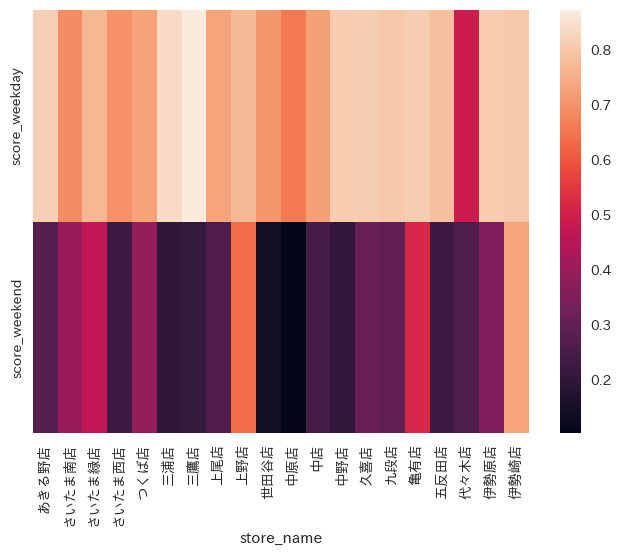

In [37]:
# ヒートマップ

sns.heatmap(pred_viz[:20].T)